In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc #ROC曲线，和AUC
from scipy import interp 

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [4]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
le.transform(['M','B'])

array([1, 0])

In [7]:
#数据集划分
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

## 在流水线中集成数据转换及评估操作
通过流水线将StandardScaler，PCA，以及LogisticsRegression对象串联起来

In [9]:
pipe_lr = Pipeline([('sc1',StandardScaler()), ('pca',PCA(n_components=2)), ('clf',LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
#使用流水线之后，无需再为测试集重新传递参数
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


## 分层k折交叉验证
sklearn中的StratifiedKFold

In [15]:
kfold = StratifiedKFold(n_splits=10,random_state=1).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, ACC: %.3f' %(k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], ACC: 0.891
Fold: 2, Class dist.: [256 153], ACC: 0.978
Fold: 3, Class dist.: [256 153], ACC: 0.978
Fold: 4, Class dist.: [256 153], ACC: 0.913
Fold: 5, Class dist.: [256 153], ACC: 0.935
Fold: 6, Class dist.: [257 153], ACC: 0.978
Fold: 7, Class dist.: [257 153], ACC: 0.933
Fold: 8, Class dist.: [257 153], ACC: 0.956
Fold: 9, Class dist.: [257 153], ACC: 0.978
Fold: 10, Class dist.: [257 153], ACC: 0.956


In [16]:
#平均性能
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [18]:
#cross_val_score 可以将不同分块的性能评估计算分布到多个CPU上处理。
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train,cv=10, n_jobs=1)

In [20]:
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


# 使用sklearn中的学习曲线函数评估模型

In [39]:
pipe_lr = Pipeline([('sc1', StandardScaler()), ('clf',LogisticRegression(penalty='l2',random_state=0))])
train_sizes, train_scores, test_scores = \
                    learning_curve(estimator=pipe_lr, 
                                   X=X_train, y=y_train, 
                                   train_sizes=np.linspace(0.1,1.0,10),
                                   cv=10,n_jobs=1)

train_sizes用于表示不同的训练数据集规模，这里使用了10种大小的训练集规模，分别是整个数据集的[0.1,0.2,...,1]倍
cv表示在学习曲线中使用的分层k折交叉验证算法的k值
返回值train_scores,表示分别在10个不同数量级的训练集上应用分层交叉验证分别得到的长度为cv的交叉验证分数数组，那么shape=（10，k)
那么通过返回值就可以计算出，在10个不同数据集上，训练集和验证集的交叉验证的模型性能评估平均分数以及性能评估分数的标准差

In [33]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

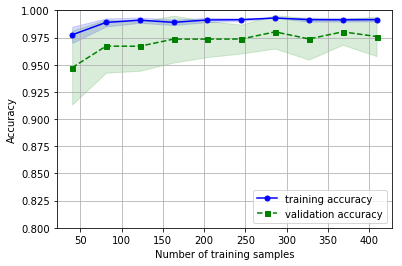

In [34]:
plt.plot(train_sizes, train_mean,color='blue',marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15,color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

通过fill_between函数加入了平均准确率标准差信息，用以表示评价结果的方差

## 通过验证曲线来判定过拟合与欠拟合

In [42]:
#逻辑斯蒂回归中正则化参数C与准确率之间的验证曲线
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
train_scores, test_scores = validation_curve( \
                                estimator=pipe_lr,
                                X=X_train,
                                y = y_train,
                                param_name='clf__C',
                                param_range=param_range,
                                cv=10)

In [50]:
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

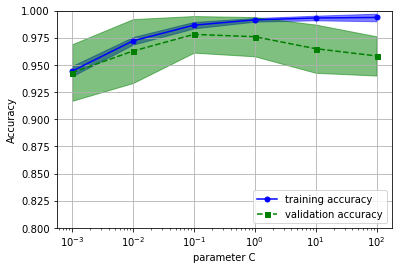

In [53]:
plt.plot(param_range, train_mean, color='blue',marker='o',markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.5, color='blue')
plt.plot(param_range, test_mean, color='green',linestyle='--',marker='s',markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.5, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

从图中可以看出，加大C值，就是降低正则化强度，模型会出现过拟合现象，训练误差和验证误差之间的差距越来越大， <br>
减小C值，就是加大正则化强度，模型会出现欠拟合现象 <br>
我们看出在C=0.1处，泛化误差最下。也就是，训练准确率与验证准确率之间的差距很小的同时保持着很高的准确率 <br>

## 使用网格搜索调优超参

In [61]:
pipe_svc = Pipeline([('sc1',StandardScaler()),
                    ('clf', SVC(random_state=1))])
param_range=[0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
#这里有两种不同svm核，一种是线性的，一种是rbf，同时比较这两者的最优模型
param_grid = [{'clf__C':param_range,
              'clf__kernel':['linear']},
             {'clf__C':param_range,
             'clf__gamma': param_range,
             'clf__kernel':['rbf']}]

In [66]:
#对支持向量机流水线的训练与调优
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring='accuracy', cv=10,n_jobs=-1)

In [67]:
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

0.978021978022


In [68]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [69]:
#使用独立的测试数据集，通过GridSearchCV对象的best_estimator_属性对最优模型进行性能评估
clf = gs.best_estimator_
clf.fit(X_train,y_train)
print('Test_Accuracy: %.3f' % clf.score(X_test, y_test))

Test_Accuracy: 0.965


## 使用sklearn中的嵌套交叉验证
使用嵌套交叉验证方法比较SVM模型与简单的决策树分类器

In [71]:
gs = GridSearchCV(estimator=pipe_svc,
               param_grid=param_grid,
               scoring='accuracy',
               cv=10,
               n_jobs=-1)

In [72]:
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


In [75]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[
                     {'max_depth':[1,2,3,4,5,6,7,None]}
                 ], scoring='accuracy',cv=5)

In [76]:
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.908 +/- 0.045


## 混淆矩阵

In [78]:
pipe_svc.fit(X_train,y_train)

Pipeline(steps=[('sc1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

In [79]:
y_pred = pipe_svc.predict(X_test)

In [80]:
confmat = confusion_matrix(y_true=y_test,y_pred =y_pred)

In [82]:
print(confmat)

[[71  1]
 [ 2 40]]


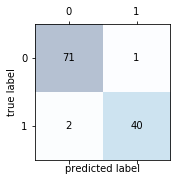

In [83]:
#使用matplotlib中的matshow函数将以图像形式显示出来
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
        
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [85]:
print('precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

precision: 0.976


In [86]:
print('recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

recall: 0.952


In [87]:
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [90]:
#通过make_scorer函数，可以把正类类标表示成0，而不是默认的1
scorer = make_scorer(f1_score, pos_label=0)

## 画出威斯康星乳腺癌数据集的ROC曲线